In [2]:
%matplotlib inline
import torch
from torch import nn
import my_RNN
from d2l import torch as d2l

In [3]:
T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))

In [4]:
tau = 15
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

In [5]:
batch_size, num_steps, n_train = 16,15,600
train_iter,vocab = my_RNN.load_x_data(x[:n_train],batch_size,num_steps),1

In [6]:
def get_params(vocab,num_hiddens):
    num_inputs = num_outputs = vocab 

    def normal(shape):
        return torch.randn(size=shape) * 0.01
    
    def three():
        return (normal((num_inputs,num_hiddens)),
                normal((num_hiddens,num_hiddens)),
                torch.zeros(num_hiddens))
    
    W_xz, W_hz, b_z = three() #遗忘门
    W_xr,W_hr,b_r = three() #重置门
    W_xh, W_hh, b_h = three() #候选隐状态

    # 输出层参数
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs)

    #附加梯度
    params = [W_xz,W_hz,b_z,W_xr,W_hr,b_r,W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params 
    


In [7]:
def init_gru_state(batch_size,num_hiddens):
    return (torch.zeros((batch_size,num_hiddens)),)

In [8]:
def gru(inputs,state,params):
    W_xz,W_hz,b_z,W_xr,W_hr,b_r,W_xh,W_hh,b_h,W_hq,b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = torch.sigmoid((X @ W_xz) + (H @ W_hz) + b_z)
        R = torch.sigmoid((X @ W_xr) + (H @ W_hr) + b_r)
        H_tilda = torch.tanh((X @ W_xh) + ((R * H) @ W_hh) + b_h)
        H = Z*H + (1-Z)*H_tilda
        Y = H @ W_hq + b_q 
        outputs.append(Y)
    return torch.cat(outputs,dim=1),(H,)

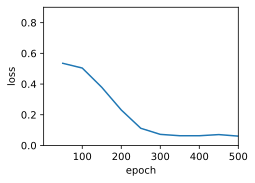

In [9]:
num_hiddens = 256 
num_epochs,lr = 500,0.01
net = my_RNN.RNNModelScratch(vocab,num_hiddens,get_params,init_gru_state,gru)
my_RNN.train(net,train_iter,vocab,lr,num_epochs)

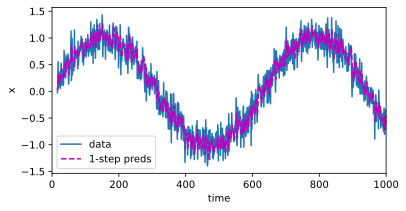

In [10]:
preds = []
for pred in features: 
    preds.append(my_RNN.predict(pred,1,net,vocab)[-1])
preds = torch.tensor(preds)

d2l.plot([time[tau:],time[tau:]],[labels,preds],xlim=[0,1000] ,
         xlabel='time',ylabel='x',legend=['data','1-step preds'],
        figsize=(6, 3))

C:\Users\zz\AppData\Local\Temp\ipykernel_10476\887080390.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(multistep_preds[i-tau:i],dtype=torch.float32),1,net,vocab)[-1]
C:\Users\zz\AppData\Local\Temp\ipykernel_10476\887080390.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  [x.detach(),torch.tensor(preds,dtype=torch.float32).detach(),


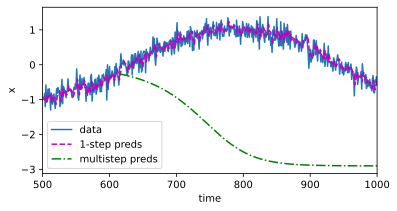

In [11]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[:n_train+tau]
for i in range(n_train+tau,T):
    multistep_preds[i] = my_RNN.predict(
        torch.tensor(multistep_preds[i-tau:i],dtype=torch.float32),1,net,vocab)[-1]
d2l.plot([time,time[tau:],time[n_train+tau:]],
         [x.detach(),torch.tensor(preds,dtype=torch.float32).detach(),
          multistep_preds[n_train+tau:].detach()],'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[500, 1000], figsize=(6, 3))

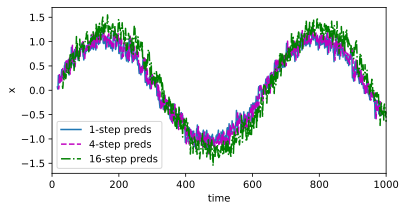

In [12]:
max_steps = 16

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
for i in range(features.shape[0]):
    for j in range(tau, tau + max_steps):
        features[i, j] = my_RNN.predict(features[i, j - tau:j],1,net,vocab)[-1]


steps = (1, 4, 16)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, tau + i - 1].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[0, 1000],
         figsize=(6, 3))